In [16]:
import sys
mainpath='c:/Kitti/Dropbox/PHD/Gridshells-EQCS' #location of folders
sys.path.insert(0, mainpath+'/Tekno') #location of python files
geompath=mainpath+'/Saved particle-spring shapes/' #location of saved particle-spring shapes

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import Tekno as tk
import Types as tp
import numpy as np
import Imperfection as imp
import Plot as ptk
from scipy.interpolate import UnivariateSpline
from plotly.graph_objs import Layout, Data, Figure, Marker
from plotly.graph_objs import Scatter3d, Scatter, Histogram
from plotly import tools
from plotly.offline import iplot as iplt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from scipy import optimize
import pickle
import pandas as pd
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import TekGeom as tg
import time

In [17]:
import importlib #for reloading
importlib.reload(tk)
import Tekno as tk
importlib.reload(imp)
import Imperfection as imp
importlib.reload(ptk)
import Plot as ptk
importlib.reload(tg)
import TekGeom as tg

# Parameters

materially and geometrically nonlinear finite element analysis to determine the ultimate load of grid shells

grid shells with various shape and pipe cross-section sizes (D, T)

to see results either load previously calculated and saved results or run analyses

In [4]:
nb=4
gN=16
D=150
t=10
Span=40
LperHA=[8,5,3] #loop
amp=Span/500
nNodes=2769

# Load results

In [8]:
ga = pickle.load( open(mainpath+"/Saved results/alak_i.p", "rb" ) )
ga_an = pickle.load( open(mainpath+"/Saved results/alak_an_i.p", "rb" ) )
with pd.HDFStore(mainpath+'/Saved results/alak_i.h5') as store:
    cpd = store['CapacityA']
    fpd = store['CapacityFA']
    lpd = store['loadA']
    dpd = store['dispA']
    cpd_an = store['CapacityA_an']
    fpd_an = store['CapacityFA_an']
    lpd_an = store['loadA_an']
    dpd_an = store['dispA_an']
    ldpd = store['lastDispA']
    #ldpd_an = store['lastDispA_an']

In [9]:
size = 7
GRSA = ga
GRSA_an = ga_an
CapacityA=np.array(cpd).reshape(size,3,3)
CapacityFA=np.array(fpd).reshape(size,3,3)
loadAA=np.array(lpd).reshape(size,3,3,201)
dispA =np.array(dpd).reshape(size,3,3,201)
CapacityA_an=np.array(cpd_an).reshape(3,3)
CapacityFA_an=np.array(fpd_an).reshape(3,3)
loadAA_an=np.array(lpd_an).reshape(3,3,201)
dispA_an =np.array(dpd_an).reshape(3,3,201)
loadAA_ani=np.array(lpd_an).reshape(3,3,201)
dispA_ani =np.array(dpd_an).reshape(3,3,201)

# Analysis

### Non-analytic shape

In [43]:
size = 7
GRSA       = np.zeros((size,3), dtype=tp.GridShell) # alak, L/H,
CapacityFA = np.zeros((size, 3, 3)) # alak, L/H, teher
CapacityA  = np.zeros((size, 3, 3))
loadAA     = np.zeros((size, 3, 3, 201))
dispA      = np.zeros((size, 3, 3, 201))
lastDispA  = np.zeros((size, 3, 3, nNodes,3))

In [ ]:
GeomType=4
for ll in range(3):
    LperH=LperHA[ll]
    Height=Span/LperH
    for j in range(3):
        alakA=[110, 210, 310, 410, 610, 810, 1010]
        for k in range(7):
            alak=alakA[k]
            count=0
            GRS = tp.GridShell(Span,Height,D,t,gN,nb,GeomType,shape=alak)
            tk.CreateGeom(GRS,geompath)
            GRS.SupType = 1
            GRS.GeomNL = 1
            GRS.MatNL = 1
            GRS.LoadType = j
            GRS.Steps = 200
            GRS.MinStepSize = 0.001
            alfa, GRS = imp.imperfection(GRS, 0, amp)
            tk.BuildOpsModel(GRS)
            q=-30.
    
            for i in range(GRS.nbnBns):
                if GRS.LoadType == 0 \
                    or (GRS.GeomType==4 and GRS.LoadType == 1 and GRS.nsAll.x[GRS.nbn[i]] <= GRS.span / 2) \
                    or (GRS.GeomType==4 and GRS.LoadType == 2 and GRS.nsAll.y[GRS.nbn[i]] <= GRS.span / 2):
                        count+=1
            if j==0: area=Span**2
            else: area=Span**2/2
            Fz=q/count*area
            print('{0:.2f}'.format(-alfa / 1000))
            disp, force, ID, loadA, ok = tk.Analyze(GRS, Fz, 0, 0)
            _ = plt.plot(disp[:,ID,2],loadA, 'go-',ms=3) # dot plot
            CapacityA[k,ll,j]=loadA[-1]*count/area
            CapacityFA[k,ll,j]=loadA[-1]
            loadAA[k,ll,j,:]=loadA
            dispA[k,ll,j,:]=disp[:,ID,2]
            lastDispA[k,ll,j,:,0]=disp[-1,:,0]
            lastDispA[k,ll,j,:,1]=disp[-1,:,1]
            lastDispA[k,ll,j,:,2]=disp[-1,:,2]
            GRSA[k,ll]=GRS

### Analytic shape

In [10]:
GRSA_an        = np.zeros(3, dtype=tp.GridShell) # L/H
CapacityFA_an = np.zeros((3, 3)) # L/H, teher
CapacityA_an  = np.zeros((3, 3))
loadAA_an     = np.zeros((3, 3, 201))
dispA_an      = np.zeros((3, 3, 201))
lastDispA_an  = np.zeros((3, 3, GRS.nbNsAll,3))

106.53
109.69
111.44
179.76
186.29
193.91
227.22
233.60
252.94


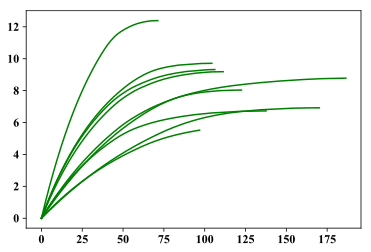

In [11]:
GeomType=2
for ll in range(3):
    LperH=LperHA[ll]
    Height=Span/LperH
    for j in range(3):
            count=0
            GRS = tp.GridShell(Span,Height,D,t,gN,nb,GeomType)
            tk.CreateGeom(GRS)
            GRS.SupType = 1
            GRS.GeomNL = 1
            GRS.MatNL = 1
            GRS.LoadType = j
            GRS.Steps = 200
            GRS.MinStepSize = 0.001
            alfa, GRS = imp.imperfection(GRS, 0, amp)
            tk.BuildOpsModel(GRS)
            print('{0:.2f}'.format(-alfa / 1000))
            q=-20.
    
            for i in range(GRS.nbnBns):
                if GRS.LoadType == 0 \
                    or (GRS.GeomType in {0, 1, 2} and GRS.LoadType == 1 and GRS.nsAll.x[GRS.nbn[i]] <= 0) \
                    or (GRS.GeomType in {0, 1, 2} and GRS.LoadType == 2 and GRS.nsAll.y[GRS.nbn[i]] <= 0) :
                        count+=1
            if j==0: area=Span**2
            else: area=Span**2/2
            Fz=q/count*area
            disp, force, ID, loadA, ok = tk.Analyze(GRS, Fz, 0, 0)
            _ = plt.plot(disp[:,ID,2],loadA*count/area, 'g') # dot plot
            CapacityA_an[ll,j]=loadA[-1]*count/area
            CapacityFA_an[ll,j]=loadA[-1]
            loadAA_an[ll,j,:]=loadA
            dispA_an[ll,j,:]=disp[:,ID,2]
            lastDispA_an[ll,j,:,0]=disp[-1,:,0]
            lastDispA_an[ll,j,:,1]=disp[-1,:,1]
            lastDispA_an[ll,j,:,2]=disp[-1,:,2]
            if j==0: GRSA_an[ll]=GRS

# Results

In [10]:
# finding the best shape
maxqA=np.zeros(3)
bestShapeA=np.zeros(3)
difA=np.zeros(3)
for ll in range(3): #L/H
    for k in range(7):
        minq=100
        for j in range(3): #load
            if minq>CapacityA[k,ll,j]:
                minq=CapacityA[k,ll,j]
        if maxqA[ll]<minq:
            dif=(maxqA[ll]-minq)/minq*100
            difA[ll]=dif
            maxqA[ll]=minq
            bestShapeA[ll]=k
print(bestShapeA,maxqA,difA)  

[ 3.  3.  2.] [  5.80195313   9.26015625  12.48105469] [ -1.56029085  -0.73399139 -16.8114173 ]


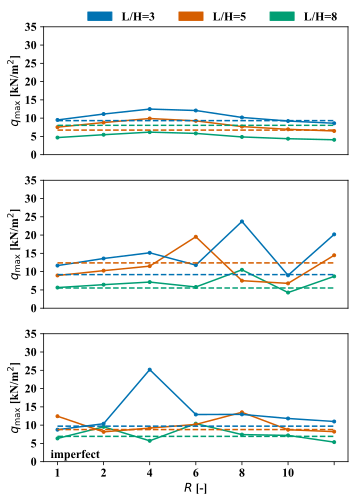

In [14]:
c1=[c/255. for c in [213., 94., 0.]] # vermillion
c2=[c/255. for c in [0, 158, 115]] # bluish green
c3=[c/255. for c in [240, 228, 66]]  # yellow
c4=[c/255. for c in [0, 114, 178]]   # blue
c5=[c/255. for c in [204, 121, 167]] # reddish purple
c6=[c/255. for c in [86, 180, 233]] # sky blue
#c1=[c/255. for c in [230, 159, 0]]   # orange
sms=3
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 2)
x=[1,2,3,4,5,6,7]

ym=35

ax1 = plt.subplot(gs[0, 0])
j=0
plt.plot(x,CapacityA[:,0,j],'o-', c=c2, ms=sms)
plt.plot(x,CapacityA[:,1,j],'o-', c=c1, ms=sms)
plt.plot(x,CapacityA[:,2,j],'o-', c=c4, ms=sms)
plt.plot([1,7],[CapacityA_an[0,j],CapacityA_an[0,j]],'--', c=c2) #analytic
plt.plot([1,7],[CapacityA_an[1,j],CapacityA_an[1,j]],'--', c=c1) #analytic
plt.plot([1,7],[CapacityA_an[2,j],CapacityA_an[2,j]],'--', c=c4) #analytic
plt.ylabel('$q_{\\rm max}$ [kN/m$^2$]')
plt.ylim(0,ym)
plt.xticks([])
plt.yticks(np.arange(0,ym+0.1,5))
c_patch = mpatches.Patch(color=c2, label='L/H=8')
b_patch = mpatches.Patch(color=c1, label='L/H=5')
g_patch = mpatches.Patch(color=c4, label='L/H=3')
plt.legend(handles=[g_patch,b_patch,c_patch],frameon=False,bbox_to_anchor=(0, 0.2, 1., 1.),ncol=3)

ax2 = plt.subplot(gs[1,0])
j=1
plt.plot(x,CapacityA[:,0,j],'o-', c=c2, ms=sms)
plt.plot(x,CapacityA[:,1,j],'o-', c=c1, ms=sms)
plt.plot(x,CapacityA[:,2,j],'o-', c=c4, ms=sms)
plt.plot([1,7],[CapacityA_an[0,j],CapacityA_an[0,j]],'--', c=c2) #analytic
plt.plot([1,7],[CapacityA_an[1,j],CapacityA_an[1,j]],'--', c=c1) #analytic
plt.plot([1,7],[CapacityA_an[2,j],CapacityA_an[2,j]],'--', c=c4) #analytic
plt.ylabel('$q_{\\rm max}$ [kN/m$^2$]')
plt.ylim(0,ym)
plt.xticks([])
plt.yticks(np.arange(0,ym+0.1,5))

ax3 = plt.subplot(gs[2,0])
j=2
plt.plot(x,CapacityA[:,0,j],'o-', c=c2, ms=sms)
plt.plot(x,CapacityA[:,1,j],'o-', c=c1, ms=sms)
plt.plot(x,CapacityA[:,2,j],'o-', c=c4, ms=sms)
plt.plot([1,7],[CapacityA_an[0,j],CapacityA_an[0,j]],'--', c=c2) #analytic
plt.plot([1,7],[CapacityA_an[1,j],CapacityA_an[1,j]],'--', c=c1) #analytic
plt.plot([1,7],[CapacityA_an[2,j],CapacityA_an[2,j]],'--', c=c4) #analytic
plt.xlabel('$R$ [-]')
plt.ylabel('$q_{\\rm max}$ [kN/m$^2$]')
plt.ylim(0,ym)
plt.yticks(np.arange(0,ym+0.1,5))
plt.xticks(x,['1', '2', '4', '6', '8', '10'])
plt.text(0.85, 1, 'imperfect')

plt.show()

# Save results

In [48]:
pickle.dump(GRSA[:,0], open(mainpath+"/Saved results/alak_0i.p", "wb" ) )
pickle.dump(GRSA[:,1], open(mainpath+"/Saved results/alak_1i.p", "wb" ) )
pickle.dump(GRSA[:,2], open(mainpath+"/Saved results/alak_2i.p", "wb" ) )
A_df = pd.DataFrame(CapacityA.flatten())
B_df = pd.DataFrame(CapacityFA.flatten())
C_df = pd.DataFrame(loadAA.flatten()) 
D_df = pd.DataFrame(dispA.flatten())
I_df = pd.DataFrame(lastDispA.flatten())
with pd.HDFStore(mainpath+'/Saved results/alak_i.h5') as store:
    store['CapacityA']  = A_df
    store['CapacityFA'] = B_df
    store['loadA']      = C_df
    store['dispA']      = D_df
    store['lastDispA']    = I_df

In [50]:
pickle.dump(GRSA_an, open(mainpath+"/Saved results/alak_ani.p", "wb" ) )
E_df = pd.DataFrame(CapacityA_an.flatten())
F_df = pd.DataFrame(CapacityFA_an.flatten())
G_df = pd.DataFrame(loadAA_an.flatten()) 
H_df = pd.DataFrame(dispA_an.flatten())
#J_df = pd.DataFrame(lastDispA_an.flatten())
with pd.HDFStore(mainpath+'/Saved results/alak_i.h5') as store:
    store['CapacityA_an']  = E_df
    store['CapacityFA_an'] = F_df
    store['loadA_an']      = G_df
    store['dispA_an']      = H_df
    #store['lastDispA_an'] = J_df